Epoch 1/100


D:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0750 - val_loss: 0.0087
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0065 - val_loss: 0.0097
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0048 - val_loss: 0.0026
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0047 - val_loss: 0.0022
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0046 - val_loss: 0.0057
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0043 - val_loss: 0.0018
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0045 - val_loss: 0.0023
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0037 - val_loss: 0.0016
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0

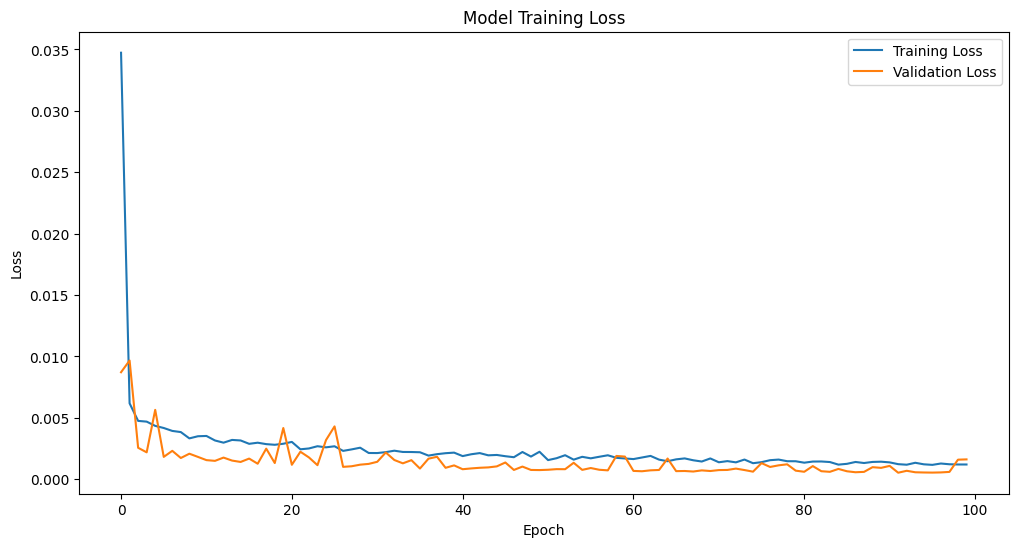

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━

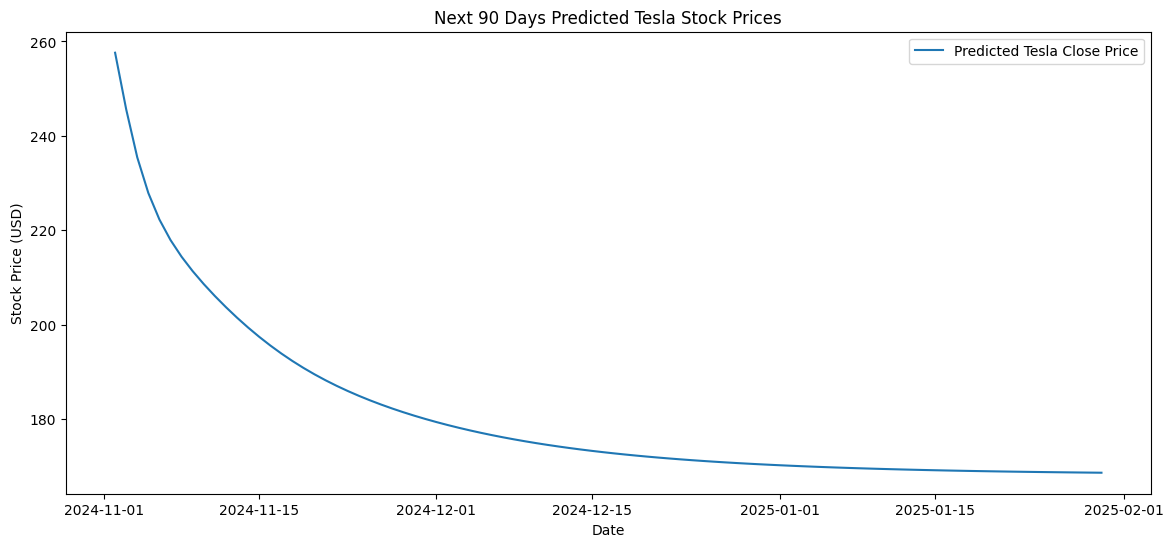

In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Step 1: Load the data
tesla_data = pd.read_csv('Tesla_Close_2019_2024.csv', parse_dates=['Date'], index_col='Date')
sp500_data = pd.read_csv('S&P500_Close_2019_2024.csv', parse_dates=['Date'], index_col='Date')
ixic_data = pd.read_csv('IXIC_Close_2019_2024.csv', parse_dates=['Date'], index_col='Date')

# Merge datasets on 'Date'
merged_data = tesla_data.merge(sp500_data, left_index=True, right_index=True, suffixes=('', '_sp500'))
merged_data = merged_data.merge(ixic_data, left_index=True, right_index=True, suffixes=('', '_ixic'))

# Step 2: Preprocess the data
data = merged_data[['Close', 'Close_sp500', 'Close_ixic']]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Prepare the dataset for LSTM
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i])
        y.append(dataset[i, 0])  # Predict the 'Close' price of Tesla
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

# Split data into training and testing sets (80-20 split)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 3: Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with early stopping for better generalization
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step 4: Iterative training on rolling windows for validation
window_size = 60  # Number of days in each rolling window
for start in range(0, len(X_train) - window_size, window_size):
    end = start + window_size
    model.fit(X_train[start:end], y_train[start:end], epochs=10, batch_size=32, verbose=0)

# Step 5: Predict the next 90 days
last_60_days = scaled_data[-60:]  # Use last 60 days for prediction
input_seq = last_60_days.reshape(1, last_60_days.shape[0], last_60_days.shape[1])

predictions = []
for _ in range(90):  # Predict next 90 days
    pred = model.predict(input_seq)
    predictions.append(pred[0, 0])
    
    # Tạo mảng mới có cùng số lượng đặc trưng như input_seq
    pred_with_features = np.array([[pred[0, 0], 0, 0]])  # Dự đoán giá trị 'Close' và thêm giá trị giả cho các cột khác
    input_seq = np.append(input_seq[:, 1:, :], pred_with_features.reshape(1, 1, 3), axis=1)  # Cập nhật input_seq

# Inverse scale predictions to original scale
predictions = scaler.inverse_transform(np.concatenate([np.array(predictions).reshape(-1, 1), 
                                                       np.zeros((90, 2))], axis=1))[:, 0]

# Plot predictions
plt.figure(figsize=(14, 6))
plt.plot(pd.date_range(start='2024-11-02', periods=90), predictions, label='Predicted Tesla Close Price')
plt.title('Next 90 Days Predicted Tesla Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

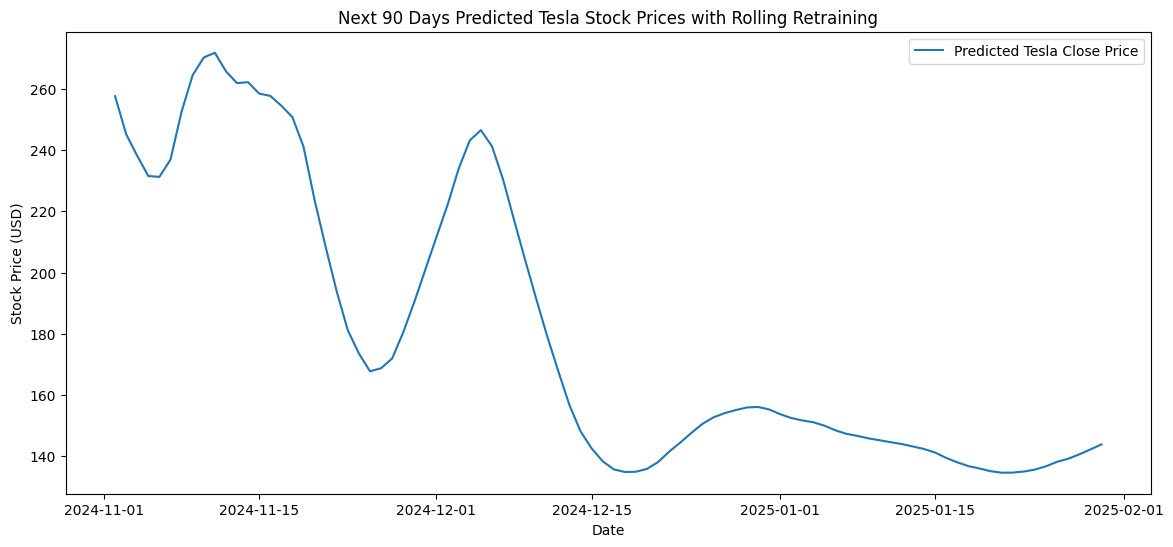

In [8]:
# Step 5: Predict the next 90 days using rolling retraining
last_60_days = scaled_data[-60:]  # Start with the last 60 days of actual data
input_seq = last_60_days.reshape(1, last_60_days.shape[0], last_60_days.shape[1])

predictions = []
for _ in range(90):  # Predict the next 90 days
    # Predict the next day
    pred = model.predict(input_seq)
    predictions.append(pred[0, 0])
    
    # Update the rolling input sequence
    pred_with_features = np.array([[pred[0, 0], 0, 0]])  # Prediction with dummy values for sp500 and ixic features
    input_seq = np.append(input_seq[:, 1:, :], pred_with_features.reshape(1, 1, 3), axis=1)
    
    # Fine-tune the model on the updated rolling window
    model.fit(input_seq, np.array([pred[0, 0]]), epochs=1, batch_size=1, verbose=0)  # Single-step fine-tuning

# Inverse scale predictions to original scale
predictions = scaler.inverse_transform(
    np.concatenate([np.array(predictions).reshape(-1, 1), np.zeros((90, 2))], axis=1)
)[:, 0]

# Plot the predictions
plt.figure(figsize=(14, 6))
plt.plot(pd.date_range(start='2024-11-02', periods=90), predictions, label='Predicted Tesla Close Price')
plt.title('Next 90 Days Predicted Tesla Stock Prices with Rolling Retraining')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()
